<a href="https://colab.research.google.com/github/Mancy-Chen/Temperature_Conversion/blob/main/Copy_of_AI4I_Radiomics_Experts_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radiomics for experts
  
<b>'Building a radiomics classifier that distinguishes between benign and malignant lesions will certainly improve clinical handling of suspicious lesions, and minimize the need for invasive procedures' - the aim of all the radiomics researchers.</b>

## Introduction

In this script, you will use a privately collected contrast enhanced spectral mammography (CESM) of 1058 patients at Maastricht University Medical Center (MUMC). You will build a classifier to differentiate between malignant and benign breast lesions. Such a model will reduce the necessity for invasive tissue biopsies. If you find this task, or parts of it, too hard, you can "cheat" by looking at the beginners notebook, as most tasks are very similar.

<b>Note:</b> this dataset is private and allowed to be used only for the purpose of this course! Nevertheless, for this notebook, we provide you with the features extracted from the data as an invert transformation is not possible. If you want to extract the features yourself, you will receive the dedicated instructions at the practical. In this case, please make sure you delete imaging data after the workshop. For this, you can use a precision-medicine-toolbox: https://github.com/primakov/precision-medicine-toolbox. For the hints, you can have a look at the beginners notebook: https://colab.research.google.com/drive/1K-sg8g2Po6Czq5utFS2F6CtetXcrwpIt?usp=sharing.

<b>Brief description</b>

Mammography is the standard imaging tool for breast-cancer screening, but is prone to false positives and lowered sensitivity in high-density breasts. Contrast enhanced spectral mammography (CESM) depicts breast lesions with more accuracy and with higher sensitivity than regular mammograms. This technique uses an iodine contrast agent in addition to a high energy and low energy mammogram to cancel out background noise and enhance the tumor. The advantage of CESM compared to regular mammography is that breast density does not affect image quality, and it boasts a sensitivity of 93-100%, compared to 75-85% of mammography on regular breasts, and lower than 50% in dense breasts.   

![picture](https://drive.google.com/uc?export=view&id=1GRt1gWtxPDXGycX6TpDAbH1XAieMQc0t)      
A typical contrast-enhanced spectral mammography (CESM) examination (only right mediolateral oblique view shown), consisting of a low-energy (a), high-energy (b) and recombined (c) image. A suspicious lesion is seen on the low-energy image, showing enhancement on the recombined image (white arrows). Histopathology showed invasive ductal carcinoma. The high-energy image is not for diagnostic purposes but is used for construction of the recombined image (Lalji, U.C., Jeukens, C.R.L.P.N., Houben, I. et al. Evaluation of low-energy contrast-enhanced spectral mammography images by comparing them to full-field digital mammography using EUREF image quality criteria. Eur Radiol 25, 2813–2820 (2015). https://doi.org/10.1007/s00330-015-3695-2)

<b>Problem</b>  

Though CESM improves the detection of breast lesions, there is still a challenge in distinguishing between benign and malignant lesions, as the specificity of CESM is estimated to be 70%. This stands to improve using machine learning (ML) algorithms.

<b>Notebook structure</b>  

The Python script will take you through the following steps:  
 - Installing packages and importing libraries,
 - Reading the data and assigning the outcomes,
 - Removing redundant features and selecting predictive features,
 - Creating the classification models.
If you still have time, go back and try balancing your data, and fine-tune your models.

## Getting started

This is an interactive Python notebook. To run it, you don't need to install anything on your PC since the script is executed in the cloud. On the left tab, you can see the 'Files' folder, that contains the data. Results of the script execution will be saved in this folder.  
  
The information about the curated imaging dataset will be distributed separately. To open DICOM files, you can use 3D Slicer (https://www.slicer.org/), RadiAnt viewer (https://www.radiantviewer.com/), or MicroDicom viewer (https://www.microdicom.com/downloads.html). As feature extraction process takes time, we prepared the Excel tables with the pre-extracted features to work with. All the data will be pulled from the shared Google Drive to the temporary environment of this notebook. Further it is explained how to get these data.

Please note, that all the files you pull or upload to this notebook, as well as the files, produced while executing the script, are automatically deleted as soon as you end the session.

First of all, the needed Python packages have to be uploaded. Some of them are not installed in the environment of this notebook, so the installation is needed with '!pip install <i>name-of-the-package</i>' command. We recommend you get acquainted with getting documentation and help on these packages. For example, google 'python sklearn' and you will get to the documentation quickly. Importing libraries is a necessary step with most progamming languages, not only Python.

In [ ]:
# installing some packages, which are not part of the present Google Collab environment

!pip install precision-medicine-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 59.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from precision-medicine-toolbox) has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 54.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Prepa

In [ ]:
import os
import numpy as np
import pandas as pd
from pmtool.AnalysisBox import AnalysisBox
from pmtool.ToolBox import ToolBox
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import xgboost as xgb



Pulling the shared files and unzipping (pay attention at 'Files' tab of this notebook):

In [ ]:
!gdown --id 1hrVNUSWmqEgLcX2slkENoCzPA9aqKy16
!unzip AI4I_Radiomics_Experts_Data.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hrVNUSWmqEgLcX2slkENoCzPA9aqKy16
To: /content/AI4I_Radiomics_Experts_Data.zip
100% 5.08M/5.08M [00:00<00:00, 33.8MB/s]
Archive:  AI4I_Radiomics_Experts_Data.zip
   creating: AI4I_Radiomics_Experts_Data/
   creating: AI4I_Radiomics_Experts_Data/data_features/
  inflating: AI4I_Radiomics_Experts_Data/data_features/WS2022_Experts_training.xlsx  
  inflating: AI4I_Radiomics_Experts_Data/data_features/WS2022_Experts_validation.xlsx  
  inflating: AI4I_Radiomics_Experts_Data/example_ct_parameters.yaml  


## Feature extraction
There are many softwares to perform this step, each with their strengths and weaknesses. Features extraction step takes the longest time, so we are happy to help you with it. We will supply you with "something we prepared earlier", the lists of features already extracted with Radiomics software, and outcomes (benign/malignant). The data is already split into train and validation sets. Therefore, you can skip this step or return to it later. If you want to skip this step, please move to 'Reading the data' step.  

If you want to extract the features by yourself anyway, you can adapt the code from the beginners notebook: https://colab.research.google.com/drive/1K-sg8g2Po6Czq5utFS2F6CtetXcrwpIt?usp=sharing. Here we perform features extraction with PyRadiomics software (https://pyradiomics.readthedocs.io/en/latest/) with the precision-medicine-toolbox (https://github.com/primakov/precision-medicine-toolbox) interface. These are the open-source Python packages. The key difference is that the present script is using Pyradiomics for feature extraction whereas in the prepared files, Radiomics software (https://radiomics.bio/) was used.

## Reading the data

For this step, you will need to specify the path to the files containing the features and outcomes (in this case 0 or 1 for benign or malignant). It is important that apart from initial dataset cleaning, all the work is only performed in the training dataset and the test set remains untouched.

<b>NOTE: the separator character, text quotation, decimal point character change depending on your country settings. If this step fails, add those settings into read_excel function. Also, the outputs from different radiomics softwares can differ wildly, so some thought is necessary when doing this at home.</b>  



In [ ]:
data_train = pd.read_excel("/content/AI4I_Radiomics_Experts_Data/data_features/WS2022_Experts_training.xlsx")
data_test = pd.read_excel("/content/AI4I_Radiomics_Experts_Data/data_features/WS2022_Experts_validation.xlsx")

# let's have a look at our dataframe:
data_train


,ID,LesionID,discretization_method,discretization_value,modality,pixel_spacing_1,pixel_spacing_2,resample_method,resample_voxel_size,structure_name,...,Stats_p90,Stats_qcod,Stats_rMeanD,Stats_range,Stats_rms,Stats_skewness,Stats_std,Stats_var,Outcome,outcome
0,B:\CESM Radiomics\Radiomics\Radiomics_Data_CES...,les0001,binnum,100,CESM,0.01,0.01,no resampling,no resampling,tumor_mask,...,2023.0,0.004737,7.835342,100,2005.338150,0.130638,13.878243,192.605617,0,0
1,B:\CESM Radiomics\Radiomics\Radiomics_Data_CES...,les0002,binnum,100,CESM,0.01,0.01,no resampling,no resampling,tumor_mask,...,2011.0,0.004514,7.665868,102,1993.833826,0.297342,13.992306,195.784623,0,0
2,B:\CESM Radiomics\Radiomics\Radiomics_Data_CES...,les0003,binnum,100,CESM,0.01,0.01,no resampling,no resampling,tumor_mask,...,2019.0,0.006267,10.396572,175,1995.360045,0.341317,19.170986,367.526705,0,0
3,B:\CESM Radiomics\Radiomics\Radiomics_Data_CES...,les0004,binnum,100,CESM,0.01,0.01,no resampling,no resampling,tumor_mask,...,2123.0,0.008126,13.983447,194,2091.914783,-0.078105,24.588163,604.577753,1,1
4,B:\CESM Radiomics\Radiomics\Radiomics_Data_CES...,les0005,binnum,100,CESM,0.01,0.01,no resampling,no resampling,tumor_mask,...,2046.0,0.005184,9.049624,115,2025.861009,0.247619,15.863846,251.661626,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,B:\CESM Radiomics\Radiomics\Radiomics_Data_CES...,les0801,binnum,100,CESM,0.01,0.01,no resampling,no resampling,tumor_mask,...,2083.0,0.010304,17.825790,317,2039.996588,0.595439,32.443675,1052.592020,1,1
801,B:\CESM Radiomics\Radiomics\Radiomics_Data_CES...,les0802,binnum,100,CESM,0.01,0.01,no resampling,no resampling,tumor_mask,...,2046.0,0.005429,8.995643,109,2025.917942,0.066771,15.670572,245.566812,1,1
802,B:\CESM Radiomics\Radiomics\Radiomics_Data_CES...,les0803,binnum,100,CESM,0.01,0.01,no resampling,no resampling,tumor_mask,...,2065.0,0.007375,12.912480,310,2034.450398,0.232657,24.818542,615.960038,1,1
803,B:\CESM Radiomics\Radiomics\Radiomics_Data_CES...,les0804,binnum,100,CESM,0.01,0.01,no resampling,no resampling,tumor_mask,...,2059.0,0.007890,13.156583,158,2028.638479,0.132928,23.448686,549.840857,1,1


<b>Getting the features and defining the outcome</b>

It's a good time to look at the .csv files using Google Tables or similar software. Ask a helper if you need assistance with this. Let's have a look at the columns and get a lis of the features from there:

In [ ]:
counter = 0
for item in data_train.columns:
  print (counter, item)
  counter += 1



0 ID
1 LesionID
2 discretization_method
3 discretization_value
4 modality
5 pixel_spacing_1
6 pixel_spacing_2
7 resample_method
8 resample_voxel_size
9 structure_name
10 voxel_distance
11 Fractal_average
12 Fractal_lacunarity
13 Fractal_sd
14 GLCM_autocorr
15 GLCM_average
16 GLCM_clusProm
17 GLCM_clusShade
18 GLCM_clusTend
19 GLCM_contrast
20 GLCM_correl1
21 GLCM_diffAvrg
22 GLCM_diffEntro
23 GLCM_diffVar
24 GLCM_dissimilar
25 GLCM_energy
26 GLCM_entrop2
27 GLCM_homogeneity1
28 GLCM_homogeneity2
29 GLCM_infoCorr1
30 GLCM_infoCorr2
31 GLCM_invDiffMomNor
32 GLCM_invDiffNorm
33 GLCM_inverseVar
34 GLCM_maxCorr
35 GLCM_maxProb
36 GLCM_sumAvg
37 GLCM_sumEntro
38 GLCM_sumSquares
39 GLCM_sumVar
40 GLDZM_DZE
41 GLDZM_DZN
42 GLDZM_DZNN
43 GLDZM_DZV
44 GLDZM_HIE
45 GLDZM_HILDE
46 GLDZM_HISDE
47 GLDZM_IN
48 GLDZM_INN
49 GLDZM_IV
50 GLDZM_LDE
51 GLDZM_LIE
52 GLDZM_LILDE
53 GLDZM_LISDE
54 GLDZM_SDE
55 GLDZM_ZP
56 GLRLM_GLN
57 GLRLM_GLNN
58 GLRLM_GLV
59 GLRLM_HGRE
60 GLRLM_LGRE
61 GLRLM_LRE
62 GLRLM_

And get list of the features: print features names from the provided file above


In [ ]:
features = list(data_train.columns)
print (len(features))
print (features)

491
['ID', 'LesionID', 'discretization_method', 'discretization_value', 'modality', 'pixel_spacing_1', 'pixel_spacing_2', 'resample_method', 'resample_voxel_size', 'structure_name', 'voxel_distance', 'Fractal_average', 'Fractal_lacunarity', 'Fractal_sd', 'GLCM_autocorr', 'GLCM_average', 'GLCM_clusProm', 'GLCM_clusShade', 'GLCM_clusTend', 'GLCM_contrast', 'GLCM_correl1', 'GLCM_diffAvrg', 'GLCM_diffEntro', 'GLCM_diffVar', 'GLCM_dissimilar', 'GLCM_energy', 'GLCM_entrop2', 'GLCM_homogeneity1', 'GLCM_homogeneity2', 'GLCM_infoCorr1', 'GLCM_infoCorr2', 'GLCM_invDiffMomNor', 'GLCM_invDiffNorm', 'GLCM_inverseVar', 'GLCM_maxCorr', 'GLCM_maxProb', 'GLCM_sumAvg', 'GLCM_sumEntro', 'GLCM_sumSquares', 'GLCM_sumVar', 'GLDZM_DZE', 'GLDZM_DZN', 'GLDZM_DZNN', 'GLDZM_DZV', 'GLDZM_HIE', 'GLDZM_HILDE', 'GLDZM_HISDE', 'GLDZM_IN', 'GLDZM_INN', 'GLDZM_IV', 'GLDZM_LDE', 'GLDZM_LIE', 'GLDZM_LILDE', 'GLDZM_LISDE', 'GLDZM_SDE', 'GLDZM_ZP', 'GLRLM_GLN', 'GLRLM_GLNN', 'GLRLM_GLV', 'GLRLM_HGRE', 'GLRLM_LGRE', 'GLRLM_

Separate the features and the outcomes:

In [ ]:
outcome_train = data_train['Outcome']
outcome_test = data_test['Outcome']
data_train = data_train.iloc[:, 11:489]
data_test = data_test.iloc[:, 11:489]

# checking how the features dataframe looks like
data_test

,Fractal_average,Fractal_lacunarity,Fractal_sd,GLCM_autocorr,GLCM_average,GLCM_clusProm,GLCM_clusShade,GLCM_clusTend,GLCM_contrast,GLCM_correl1,...,Stats_min,Stats_p10,Stats_p90,Stats_qcod,Stats_rMeanD,Stats_range,Stats_rms,Stats_skewness,Stats_std,Stats_var
0,2.109282,0.010447,0.215554,2067.797029,43.798278,1.407646e+06,7159.400380,659.846733,61.815929,0.828684,...,1952,2005.0,2072.0,0.008593,14.702153,197,2037.443275,0.380419,26.447025,699.445119
1,2.092324,0.013189,0.240349,3058.445449,54.750456,4.812933e+05,-1520.370488,363.746544,120.416026,0.502632,...,1941,2003.0,2045.0,0.005435,9.501333,153,2024.170365,-0.192629,16.779550,281.553291
2,2.150168,0.010916,0.224781,1635.345051,39.827543,3.878116e+05,550.338057,361.060041,164.613393,0.373679,...,1948,1983.0,2024.0,0.005241,9.146604,141,2003.600820,0.061260,16.197340,262.353813
3,2.063521,0.014229,0.246219,2826.252979,52.173545,1.058322e+06,456.179418,570.204419,153.516593,0.575638,...,1947,1991.0,2034.0,0.005467,9.466079,126,2011.960535,0.022882,17.024644,289.838490
4,2.036999,0.012901,0.231412,3746.556382,59.727643,1.595368e+06,-7379.912876,777.424703,60.774660,0.854920,...,1968,2038.0,2106.0,0.009161,15.768983,179,2073.695786,-0.295346,26.140395,683.320268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,2.100960,0.012393,0.233880,2221.622474,45.785092,1.268940e+06,6745.077260,637.488194,136.100367,0.648064,...,1994,2025.0,2064.0,0.005138,8.544133,110,2043.806439,0.330860,15.341589,235.364338
337,2.127763,0.011310,0.226349,3035.236201,53.758531,1.362019e+06,-4222.473364,713.990413,132.968675,0.685966,...,1973,2025.0,2084.0,0.007782,13.345616,155,2055.414637,-0.163142,22.641186,512.623307
338,2.140162,0.011835,0.232799,3505.057172,58.783398,4.152072e+05,-375.705536,370.632807,172.356402,0.365138,...,1926,1980.0,2017.0,0.004754,8.203036,124,1998.365225,-0.042320,14.446493,208.701167
339,2.140218,0.011237,0.226827,2604.640174,50.430707,5.529747e+05,-1726.052467,413.059270,167.524630,0.422830,...,1959,2001.0,2037.0,0.004704,8.076171,121,2019.393275,-0.106028,14.609857,213.447917


## Exploratory data analysis

Before building the models, it is always useful to perform the exploratory data analysis to have a look at the data, understand the distribution of the features, and notice some data errors. To perform these steps, we will be using precision-medicine-toolbox (https://github.com/primakov/precision-medicine-toolbox), an open-source Python package, developed in the D-Lab, Maastricht University. If something does not work, look at the error and at the already produced features reports for troubleshooting. Don't hesitate to look into the toolbox documentation to fix the problem: https://precision-medicine-toolbox.readthedocs.io/en/latest/?badge=latest. You can search for available functions to deal with NaN values + the ways to read the data, excluding some features.  
  
Remember that for now, everything happens in the training data. Time to discuss why this is so important!  

In [ ]:
# let's list the parameters of our features dataset
parameters = {
    'feature_path': "/content/AI4I_Radiomics_Experts_Data/data_features/WS2022_Experts_training.xlsx", # path to csv/xls file with features
    'outcome_path': "/content/AI4I_Radiomics_Experts_Data/data_features/WS2022_Experts_training.xlsx", #path to csv/xls file with outcome (in our case - the same file)
    'patient_column': 'LesionID', # name of column with patient ID
    'patient_in_outcome_column': 'LesionID', # name of column with patient ID in clinical data file
    'outcome_column': 'Outcome', # name of outcome column
    'feature_column': features,
    'feature_column_to_drop': ['LoG_sigma_0_4_mm_2D_IH_max',
                               'LoG_sigma_0_7_mm_2D_IH_max',
                               'LoG_sigma_0_4_mm_2D_pos_IH_range',
                               'LoG_sigma_0_4_mm_2D_pos_IH_min',
                               'LoG_sigma_0_1_mm_2D_pos_IH_max',
                               'LoG_sigma_1_mm_2D_IH_max',
                               'LoG_sigma_0_7_mm_2D_IH_range',
                               'LoG_sigma_1_mm_2D_pos_IH_max',
                               'LoG_sigma_0_4_mm_2D_IH_min',
                               'LoG_sigma_0_1_mm_2D_pos_IH_range',
                               'LoG_sigma_0_1_mm_2D_IH_range',
                               'LoG_sigma_1_mm_2D_IH_min',
                               'LoG_sigma_0_4_mm_2D_IH_range',
                               'LoG_sigma_1_mm_2D_pos_IH_range',
                               'voxel_distance',
                               'LoG_sigma_0_1_mm_2D_IH_max',
                               'LoG_sigma_0_7_mm_2D_pos_IH_max',
                               'LoG_sigma_1_mm_2D_IH_range',
                               'LoG_sigma_0_4_mm_2D_pos_IH_max',
                               'LoG_sigma_0_7_mm_2D_pos_IH_min',
                               'LoG_sigma_1_mm_2D_pos_IH_min',
                               'LoG_sigma_0_1_mm_2D_pos_IH_min',
                               'LoG_sigma_0_7_mm_2D_IH_min',
                               'LoG_sigma_0_7_mm_2D_pos_IH_range',
                               'LoG_sigma_0_1_mm_2D_IH_min']
}

# initializing the dataset, containing features
fs = AnalysisBox(**parameters)

Number of observations: 805
Class labels: ['0' '1']
Classes balance: [0.484472049689441, 0.515527950310559]


In [ ]:
print('Initial amount of features: ', len(parameters['feature_column']))
fs.handle_nan(axis=1)
print('Amount of features after exclusion of NaN values: ', len(parameters['feature_column']))

Initial amount of features:  491
Number of observations: 805
Class labels: ['0' '1']
Classes balance: [0.484472049689441, 0.515527950310559]
Amount of features after exclusion of NaN values:  491


Plotting feature distributions to have a visual understanding about feature distributions in classes.

In [ ]:
fs.plot_distribution(fs._feature_column[11:489])

What do you think about the report?

Plotting the correlation matrix to have an idea about how many features are inter-correlated. Why is it important to know about the mutual feature correlation?

In [ ]:
fs.plot_correlation_matrix(fs._feature_column[11:489])

Performing Mann-Whitney U-test (with False Discovery Rate correction) to see if the feature distributions in classes are statistically different.

In [ ]:
fs.plot_MW_p(fs._feature_column[11:489])

Plotting univariate ROC curves and calculating AUC scores to have some estimation of the predictive power of every separate feature. Can we just build a classifer based on the best feature?

In [ ]:
auc_threshold=0.70
fs.plot_univariate_roc(fs._feature_column[11:489], auc_threshold)

Writing the basic statistics for every feature into .csv file and having a look at the resulting dataframe.

In [ ]:
fs.calculate_basic_stats()

print('Basic statistics for each feature')
pd.read_excel('/content/AI4I_Radiomics_Experts_Data/data_features/WS2022_Experts_training_basic_stats.xlsx')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1813: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.



Basic statistics for each feature


,Unnamed: 0,NaN,Mean,Std,Min,Max,p_MW_corrected,univar_auc,p_shapiro_test
0,LoG_sigma_0_7_mm_2D_pos_IH_energy,0,3.926820e+07,5.393561e+07,518632.000000,7.043464e+08,1.000000e+00,0.509608,2.835387e-41
1,GLCM_dissimilar,0,8.780048e+00,2.486709e+00,1.348561,1.677017e+01,2.600422e-14,0.671072,1.445258e-03
2,GLDZM_DZN,0,3.601086e+02,2.328494e+02,53.133739,1.812547e+03,1.000000e+00,0.548681,1.965046e-32
3,LoG_sigma_0_4_mm_2D_pos_Stats_p10,0,1.416982e+01,2.417120e+00,7.023779,1.825709e+01,1.000000e+00,0.519138,3.753181e-20
4,LoG_sigma_1_mm_2D_Stats_kurtosis,0,3.984657e+00,9.740350e+00,1.660827,2.170905e+02,1.000000e+00,0.506642,0.000000e+00
...,...,...,...,...,...,...,...,...,...
453,LoG_sigma_0_1_mm_2D_pos_IH_minGrad,0,-3.814224e+01,7.645547e+01,-1209.000000,-2.500000e+00,1.000000e+00,0.556271,0.000000e+00
454,GLRLM_GLN,0,5.794591e+02,1.596445e+03,6.578627,2.782701e+04,1.000000e+00,0.545913,0.000000e+00
455,LoG_sigma_0_7_mm_2D_IH_std,0,1.622515e+01,3.565417e+00,1.729513,3.090779e+01,1.000000e+00,0.503160,2.338162e-07
456,LoG_sigma_0_7_mm_2D_IH_var,0,2.759520e+02,1.142765e+02,2.991217,9.552917e+02,1.000000e+00,0.503089,2.877190e-11


## Features reduction and selection

Do you think we need to change somehow features list, based on the exploratory analysis?

In [ ]:
features = features[11:489]
features_non_nan = data_train[features].dropna(axis=1).columns
print ('Number of features without missing values: ', len(features_non_nan))

features_non_zero_var = data_train[features_non_nan].loc[:,data_train[features_non_nan].std(numeric_only = True) > 0.3].columns
print ('Number of features with non-zero variance: ', len(features_non_zero_var))

Number of features without missing values:  478
Number of features with non-zero variance:  366


Removing highly correlated features is a controversial step aimed to reduce the dimensionality of the feature space. Highly correlated features needlessly inflate the dimensionality of feature space. The idea is that highly correlated features can be grouped together and represented by one representative feature.  For features pairs with a high Spearman correlation (r > 0.9) the feature with the highest mean correlation with all remaining features is removed.
The opponents to this step argue that just because features are correlated doesn't mean that they don't individually  increase the model's performance.
Time to discuss the pro's and con's of this step in more detail!

<b>If you have time at the end of today's workshop, the cutoff is certaily a variable that can be played with.</b>

In [ ]:
def selectNonIntercorrelated(df_in, ftrs, corr_th):

    # selection of the features, which are not 'highly intercorrelated' (correlation is defined by Spearman coefficient);
    # pairwise correlation between all the features is calculated,
    # from each pair of features, considered as intercorrelated,
    # feature with maximum sum of all the pairwise Spearman correlation coefficients is a 'candidate to be dropped'
    # for stability of the selected features, bootstrapping approach is used:
    # in each bootstrap split, the random subsample, stratified in relation to outcome,
    # is formed, based on original observations from input dataset;
    # in each bootstrap split, 'candidates to be dropped' are detected;
    # for each input feature, its frequency to appear as 'candidate to be dropped' is calculated,
    # features, appeared in 50 % of splits as 'candidate to be dropped', are excluded from feature set

    # input:
    # df_in - input dataframe, containing feature values (dataframe, columns = features, rows = observations),
    # ftrs - list of dataframe features, used in analysis (list of feature names - string variables),
    # corr_th - threshold for Spearman correlation coefficient, defining each pair of features as intercorrelated (float)

    # output:
    # non_intercorrelated_features - list of names of features, which did not appear as inter-correlated

    corr_matrix = df_in.corr(method='spearman').abs()
    mean_absolute_corr = corr_matrix.mean()
    intercorrelated_features_set = []
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    high_corrs = upper.where(upper > corr_th).dropna(how='all', axis=1).dropna(how='all', axis=0)

    for feature in high_corrs.columns:
        mean_absolute_main = mean_absolute_corr[feature]
        correlated_with_feature = high_corrs[feature].index[pd.notnull(high_corrs[feature])]
        for each_correlated_feature in correlated_with_feature:
            mean_absolute = mean_absolute_corr[each_correlated_feature]
            if mean_absolute_main > mean_absolute:
                if feature not in intercorrelated_features_set:
                    intercorrelated_features_set.append(feature)
            else:
                if each_correlated_feature not in intercorrelated_features_set:
                    intercorrelated_features_set.append(each_correlated_feature)

    non_intercorrelated_features_set = [e for e in ftrs if e not in intercorrelated_features_set]

    print ('Non intercorrelated features: ', non_intercorrelated_features_set)

    return non_intercorrelated_features_set

We will use a threshold of 0.9 for absolute value of Spearmann's correlation.

In [ ]:
features_non_intercorrelated = selectNonIntercorrelated(data_train,features_non_zero_var, 0.9)
print ('Number of non-intercorrelated features: ', len(features_non_intercorrelated))

<ipython-input-74-b4112132d521>:22: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Non intercorrelated features:  ['GLCM_clusShade', 'GLCM_entrop2', 'GLDZM_DZE', 'GLDZM_HILDE', 'GLDZM_HISDE', 'GLDZM_LILDE', 'GLRLM_LRHGE', 'GLSZM_HILAE', 'LoG_sigma_0_1_mm_2D_IH_maxGradI', 'LoG_sigma_0_1_mm_2D_IH_medianD', 'LoG_sigma_0_1_mm_2D_IH_minGradI', 'LoG_sigma_0_1_mm_2D_IH_mode', 'LoG_sigma_0_1_mm_2D_IH_p10', 'LoG_sigma_0_1_mm_2D_IH_p90', 'LoG_sigma_0_1_mm_2D_IH_rms', 'LoG_sigma_0_1_mm_2D_IH_skewness', 'LoG_sigma_0_1_mm_2D_Stats_cov', 'LoG_sigma_0_1_mm_2D_Stats_kurtosis', 'LoG_sigma_0_1_mm_2D_Stats_mean', 'LoG_sigma_0_1_mm_2D_Stats_min', 'LoG_sigma_0_1_mm_2D_Stats_qcod', 'LoG_sigma_0_1_mm_2D_pos_IH_maxGrad', 'LoG_sigma_0_1_mm_2D_pos_IH_maxGradI', 'LoG_sigma_0_1_mm_2D_pos_IH_minGrad', 'LoG_sigma_0_1_mm_2D_pos_IH_minGradI', 'LoG_sigma_0_1_mm_2D_pos_IH_mode', 'LoG_sigma_0_1_mm_2D_pos_IH_p10', 'LoG_sigma_0_1_mm_2D_pos_Stats_max', 'LoG_sigma_0_1_mm_2D_pos_Stats_skewness', 'LoG_sigma_0_4_mm_2D_IH_maxGradI', 'LoG_sigma_0_4_mm_2D_IH_mean', 'LoG_sigma_0_4_mm_2D_IH_medianD', 'LoG_sigma_0

<ipython-input-74-b4112132d521>:25: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



We will perform feature selection using Recursive Feature Elimination (RFE). In this step, feature selection is based on the outcome, so simple models are built and those features that contribute the least to the model are removed recursively. Here you can edit the parameters.

<b>You might have heard of variable normalization. Why are we not normalizing the variables (e.g. Z-score normalization)?</b>
Hint: e.g. https://stackoverflow.com/questions/57339104/is-normalization-necessary-for-randomforest

<b>How many features do we need to select with RFE?
Time to discuss pros and cons of using many and a little features.</b>  
  
There are some rules of thumb on how many features we need in the end:  
* $int(\frac{N_{samples}}{10})$ (Abu-Mostafa, Y. S., Magdon-Ismail, M., & Lin, H. T. (2012). Learning from data (Vol. 4, p. 4). New York: AMLBook.)  
* $\sqrt{N_{samples}}$ (Hua, J., Xiong, Z., Lowey, J., Suh, E., & Dougherty, E. R. (2005). Optimal number of features as a function of sample size for various classification rules. Bioinformatics, 21(8), 1509-1515.)

In [ ]:
print ('Nmber of samples in training dataset: ', data_train.shape[0])
print ('Number of features to select according to Abu-Mostafa: ', int(data_train.shape[0]/10))
print ('Number of features to select according to Hua: ', data_train.shape[0] ** 0.5)

Nmber of samples in training dataset:  805
Number of features to select according to Abu-Mostafa:  80
Number of features to select according to Hua:  28.372521918222215


Let's go for the lower number of features since our dataset is not large. Below we implement Recursive Feature Elimination, RFE (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), based on Random Forest Classifier, RFC (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Which number of features will you chose?

In [ ]:
estimator = RandomForestClassifier(n_estimators=100, random_state=np.random.seed(0))
selector = RFE(estimator, n_features_to_select=20, step=1)
selector = selector.fit(data_train[features_non_intercorrelated], outcome_train)

And then select the features 'supported' by the algorithm.

In [ ]:
support = selector.get_support()
selected_features_set = data_train[features_non_intercorrelated].loc[:, support].columns.tolist()

print (selected_features_set)

['GLCM_clusShade', 'GLDZM_HILDE', 'GLDZM_HISDE', 'GLDZM_LILDE', 'GLSZM_HILAE', 'LoG_sigma_0_1_mm_2D_IH_rms', 'LoG_sigma_0_1_mm_2D_IH_skewness', 'LoG_sigma_0_1_mm_2D_Stats_kurtosis', 'LoG_sigma_0_1_mm_2D_Stats_mean', 'LoG_sigma_0_1_mm_2D_Stats_min', 'LoG_sigma_0_4_mm_2D_Stats_median', 'LoG_sigma_0_4_mm_2D_pos_IH_skewness', 'LoG_sigma_0_4_mm_2D_pos_Stats_max', 'LoG_sigma_1_mm_2D_Stats_iqr', 'LoG_sigma_1_mm_2D_Stats_min', 'LoG_sigma_1_mm_2D_pos_Stats_p10', 'Stats_max', 'Stats_medianD', 'Stats_p10', 'Stats_range']


<b>How many features give the best performance?</b>

Time to discuss why we don't just use 100 features!  
  
The other option to select a number of features is data-driven and is based on ranking the features and then building classifier adding +1 feature at every step and checking its performance. We can evaluate the performance with some score and plot the dependence of this score from the number of the selected features.

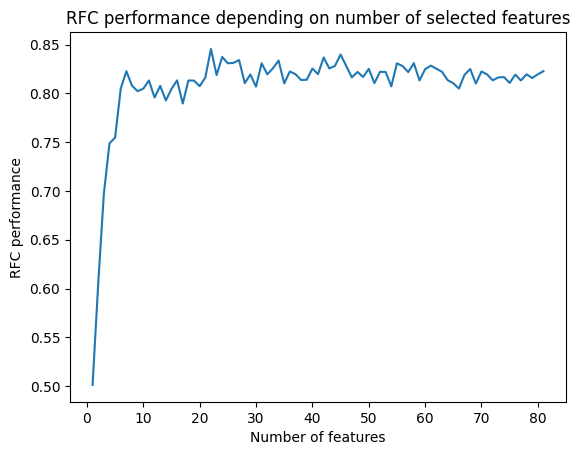

In [ ]:
# ranking the features based on RFE results

features_ranks = pd.DataFrame({'Features': features_non_intercorrelated, 'Ranks': selector.ranking_})
features_ranks.sort_values(by='Ranks', inplace = True)

# taking one best feature first, building the RFC, estimating the performance;
# adding +1 next feature, repeating the steps to estimate the performance

ftrs_number_tuning = []
acc_tuning = []

for i in range (1, len(features_ranks)):

    ftrs_number_tuning.append(i)
    estimator_tuning = RandomForestClassifier(n_estimators=100, random_state=np.random.seed(0))
    estimator_tuning.fit(data_train[features_ranks['Features'][:i]], outcome_train)
    outcome_pred_tuning = estimator_tuning.predict(data_test[features_ranks['Features'][:i]])
    acc_tuning.append(balanced_accuracy_score(outcome_test, outcome_pred_tuning))

# plotting the results
plt.plot(ftrs_number_tuning, acc_tuning)
plt.xlabel('Number of features')
plt.ylabel('RFC performance')
plt.title('RFC performance depending on number of selected features')
plt.show()

What can we conclude from the plot? What are the downsides of the presented implementation? Is it correct to train and evaluate the model on the same samples? Is the selected performance metric correct? What other metrics can we use?

## Modeling



### MODEL 1: RFC

We started with RFC while performing RFE, so let us train this model with the selected features and evaluate in on test data.  

Training the model (it's possible to vary the parameters):

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=np.random.seed(0))
rfc.fit(data_train[selected_features_set], data_train['Outcome'])

RandomForestClassifier()

Prediction for the testing set:

In [ ]:
outcome_pred_rfc = rfc.predict(data_test[selected_features_set])

Performance reporting on some key classification scores:

In [ ]:
print (classification_report(data_test['Outcome'], outcome_pred_rfc))

              precision    recall  f1-score   support

           0       0.87      0.75      0.81       166
           1       0.79      0.90      0.84       175

    accuracy                           0.83       341
   macro avg       0.83      0.83      0.83       341
weighted avg       0.83      0.83      0.83       341



Are precision and recall informative metrics? Why don't we report accuracy as a key metric? In which cases accuracy is not suitable scores?  
  
The other popular metric for classification is Receiver Operating Characteristic (ROC) curve and area under the curve (AUC). We will calculate true positive rates (TPR) and false positive rates (FPR) while varying classification threshold and plot the curve.

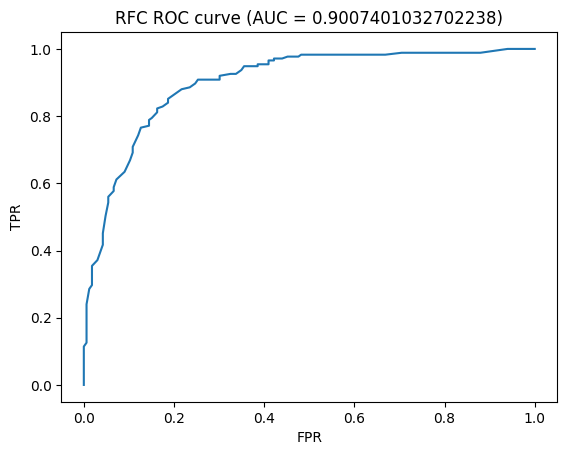

In [ ]:
fpr, tpr, _ = roc_curve(outcome_test, rfc.predict_proba(data_test[selected_features_set])[:, 1])
roc_auc = roc_auc_score(outcome_test,rfc.predict_proba(data_test[selected_features_set])[:, 1])

plt.plot(fpr, tpr)
plt.title('RFC ROC curve (AUC = {})'.format(roc_auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In which cases this metric does not give a correct representation of the model performance? Is AUC always the best metric?
Most cetainly not! Especially for unbalanced datasets, AUC can be meaningless.
http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/
"With imbalanced classes, it’s easy to get a high accuracy without actually making useful predictions. So, accuracy as an evaluation metrics makes sense only if the class labels are uniformly distributed"    

To have a better understanding of model behaviour, we will plot a confusion matrix.

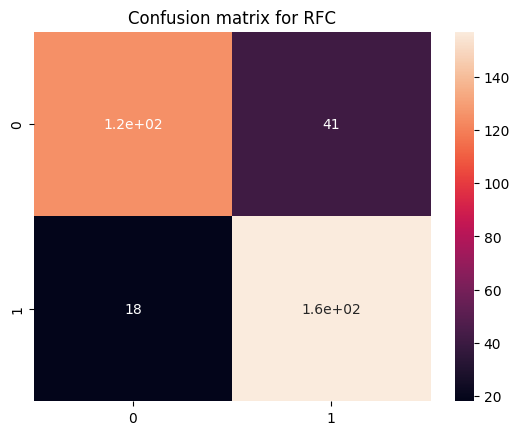

In [ ]:
cm = confusion_matrix(data_test['Outcome'], outcome_pred_rfc)
f = sns.heatmap(cm, annot=True)
plt.title('Confusion matrix for RFC')
plt.show()



### MODEL 2: XGBoost

The second model we will build is XGBoost because recently the algorithm was successfull in many machine learning competitions.

<b>XGBoost - what is it? It's always best to understand your models. </b>

https://xgboost.readthedocs.io/en/stable/python/python_intro.html#

Train the model: Here you can chose the max number of boosting iterations, a balance between computing time and accuracy.

Presenting the data in the appropriate format for the library.

In [ ]:
dtrain = xgb.DMatrix(data_train[selected_features_set], label=data_train['Outcome'])
dtest = xgb.DMatrix(data_test[selected_features_set], label=data_test['Outcome'])

Defining the parameters: the learning objective is logistic regression for binary classification with probability output, the metric is the area under precision-recall curve (why not ROC AUC?).

In [ ]:
param = {'objective': 'binary:logistic', 'eval_metric': 'aucpr'}

We will train the model on the training set and evaluate on test set.

In [ ]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

Training the model (number of iterations can be changed here!) and calculating outcomes for the test set.

In [ ]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

outcome_pred_xgb = bst.predict(dtest)

[0]	eval-aucpr:0.75716	train-aucpr:0.91104
[1]	eval-aucpr:0.78922	train-aucpr:0.94963
[2]	eval-aucpr:0.82978	train-aucpr:0.96327
[3]	eval-aucpr:0.83746	train-aucpr:0.97322
[4]	eval-aucpr:0.82722	train-aucpr:0.98234
[5]	eval-aucpr:0.84065	train-aucpr:0.98822
[6]	eval-aucpr:0.84117	train-aucpr:0.99184
[7]	eval-aucpr:0.84958	train-aucpr:0.99475
[8]	eval-aucpr:0.85601	train-aucpr:0.99659
[9]	eval-aucpr:0.86305	train-aucpr:0.99717


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning:

Pass `evals` as keyword args.



Classification report:

In [ ]:
print (classification_report(data_test['Outcome'], outcome_pred_xgb >0.5))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       166
           1       0.79      0.86      0.82       175

    accuracy                           0.81       341
   macro avg       0.81      0.81      0.81       341
weighted avg       0.81      0.81      0.81       341



ROC and ROC AUC:

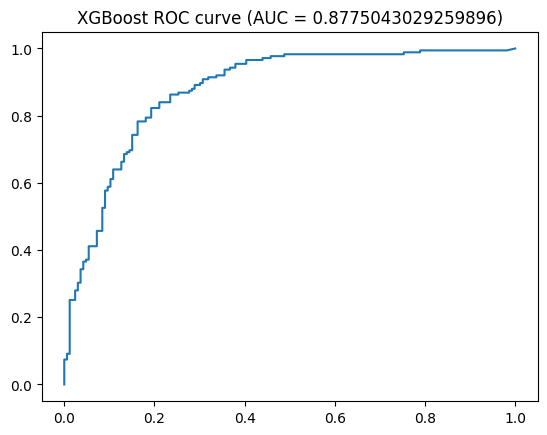

In [ ]:
fpr, tpr, _ = roc_curve(outcome_test, outcome_pred_xgb )
roc_auc = roc_auc_score(outcome_test, outcome_pred_xgb )

plt.plot(fpr, tpr)
plt.title('XGBoost ROC curve (AUC = {})'.format(roc_auc))
plt.show()

Create and display the confusion matrix and derived values for the Xgboost model.

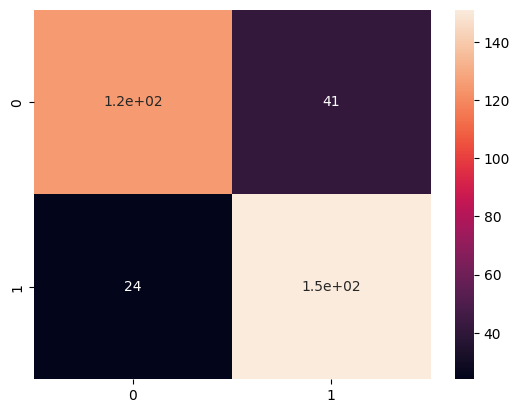

In [ ]:
cm = confusion_matrix(outcome_test, outcome_pred_xgb>0.5)
f = sns.heatmap(cm, annot=True)

<b>Almost done! You will now compare the performance of the models.</b>
  
Which classifier is better?  

To compare ROC AUC scores, we will perform a permuation test for the probabilities obtained on the test set for the both classifiers.

In [ ]:
# adapted from https://stackoverflow.com/questions/52373318/how-to-compare-roc-auc-scores-of-different-binary-classifiers
#-and-assess-statist

def permutation_test_between_clfs(y_test, pred_proba_1, pred_proba_2, nsamples=100):
    auc_differences = []
    auc1 = roc_auc_score(y_test.ravel(), pred_proba_1.ravel())
    auc2 = roc_auc_score(y_test.ravel(), pred_proba_2.ravel())
    observed_difference = auc1 - auc2
    for _ in range(nsamples):
        mask = np.random.randint(2, size=len(pred_proba_1.ravel()))
        p1 = np.where(mask, pred_proba_1.ravel(), pred_proba_2.ravel())
        p2 = np.where(mask, pred_proba_2.ravel(), pred_proba_1.ravel())
        auc1 = roc_auc_score(y_test.ravel(), p1)
        auc2 = roc_auc_score(y_test.ravel(), p2)
        auc_differences.append(auc1 - auc2)
    return observed_difference, np.mean(auc_differences >= observed_difference)

print ('Difference, p-value: ',
       permutation_test_between_clfs(outcome_test,
                                     outcome_pred_xgb,
                                     rfc.predict_proba(data_test[selected_features_set])[:,1]))

Difference, p-value:  (-0.023235800344234225, 0.99)


After this test, which classifier is better?  
  
<b>Time for a pre-hackathon!</b> You can go back and "finetune" the models (or even implement your models) by changing the parameters you feel comfortable with. See you can increase the model performance. Can you beat the other groups?

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.0 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV

X = data_train[selected_features_set]
y = data_train['Outcome']

# Define the number of folds for cross-validation
n_folds = 5

# Create a StratifiedKFold object for cross-validation
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

In [ ]:
# XGBoost
# Define the parameter space for skopt
param_space = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (100, 500),
    'gamma': (0, 10),
    'min_child_weight': (1, 10)
}
# Initialize a BayesSearchCV object with XGBoost classifier and the parameter space
opt = BayesSearchCV(
    estimator=xgb.XGBClassifier(),
    search_spaces=param_space,
    scoring='accuracy',
    cv=skf,
    n_jobs=-1,
    random_state=42
)

In [ ]:
# Random Forest
# Define the parameter bounds for Bayesian optimization
param_space = {
    'n_estimators': (50, 200),
    'max_depth': (5, 15),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'max_features': (0.1, 1.0)
}

# Initialize a BayesSearchCV object with XGBoost classifier and the parameter space
opt = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=param_space,
    scoring='accuracy',
    cv=skf,
    n_jobs=-1,
    random_state=42
)

In [ ]:
# Perform the Bayesian optimization with cross-validation
opt.fit(X, y)

# Retrieve the best estimator from the optimization
best_model = opt.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(opt.best_params_)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Best Hyperparameters:
OrderedDict([('max_depth', 15), ('max_features', 0.1), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])


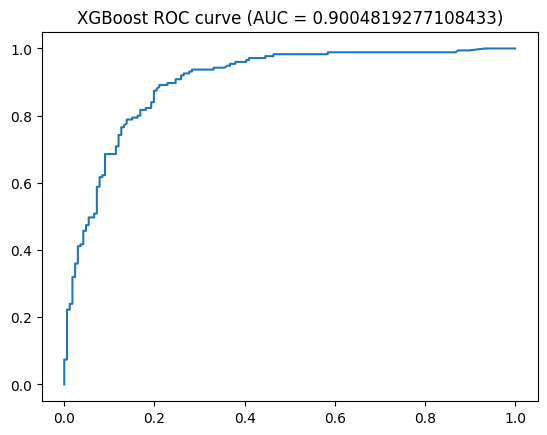

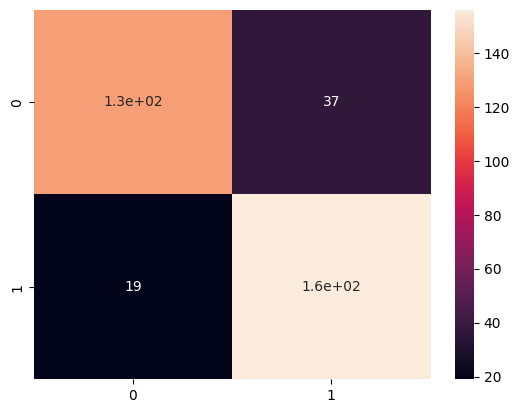

In [ ]:
# Predict the label y with the best model
y_true = data_test['Outcome']
y_score = best_model.predict_proba(data_test[selected_features_set])[:, 1]

# Plot the ROC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)
plt.plot(fpr, tpr)
plt.title('XGBoost ROC curve (AUC = {})'.format(roc_auc))
plt.show()

# Plot the Confusion Matrix
cm = confusion_matrix(y_true, y_score>0.5)
f = sns.heatmap(cm, annot=True)